In [88]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [ ]:
# Load the training data
train = pd.read_csv('data/train.csv')

# Break up stacked features
train[['Group','GroupNumber']]=train.PassengerId.str.split('_',expand=True)
train.drop('PassengerId', axis=1, inplace=True)

# train[['Deck','CabinNumber', 'Side']]=train.Cabin.str.split('/',expand=True)
train.drop('Cabin', axis=1, inplace=True)

# # Convert boolean to numbers
# train.CryoSleep = train.CryoSleep*1
# train.VIP = train.VIP*1

# Drop useless features
train.drop('Name', axis=1, inplace=True)
train.drop('Destination', axis = 1, inplace = True)
train.drop('HomePlanet', axis = 1, inplace = True)
train.drop('CryoSleep', axis = 1, inplace = True)

# Fill NA money columns with 0
train[['RoomService','FoodCourt','ShoppingMall','Spa', 'VRDeck']] = \
    train[['RoomService','FoodCourt','ShoppingMall','Spa', 'VRDeck']].fillna(value=0)

# Makeup some new features
train['TotalSpent'] = train['RoomService'] + train['FoodCourt'] + \
    train['ShoppingMall'] + train['Spa'] + train['VRDeck']

# Correct data types
# train = train.astype({
#     "Group": float, 
#     "GroupNumber": float,
#     "CabinNumber": float
# })
train = train.astype({
    "Group": float, 
    "GroupNumber": float,
})
# Create some dummies
train = pd.get_dummies(train, drop_first = True)

# Sneak Peak!
train.head()

In [ ]:
train.isna().sum()

In [ ]:
train.dropna(inplace=True)

In [ ]:
# Create features and predictor
X = train.drop('Transported', axis=1)
y = train['Transported']

# Traing, test, and split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
ada = AdaBoostClassifier()
grb = GradientBoostingClassifier()
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "NaiveBayes"),
    (grb, 'GradientBoost'),
    (ada, 'AdaBoost'),
    (rfc, "RandomForest"),
]

s = []
m = []
for i, (clf, name) in enumerate(clf_list):
    p = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    s.append(accuracy_score(y_test, p.round()))
    m.append(name)

modelSelection = pd.DataFrame(m, columns=['Model'])
modelSelection['Score'] = s
modelSelection.sort_values("Score", inplace=True, ascending=False)

modelSelection.head()

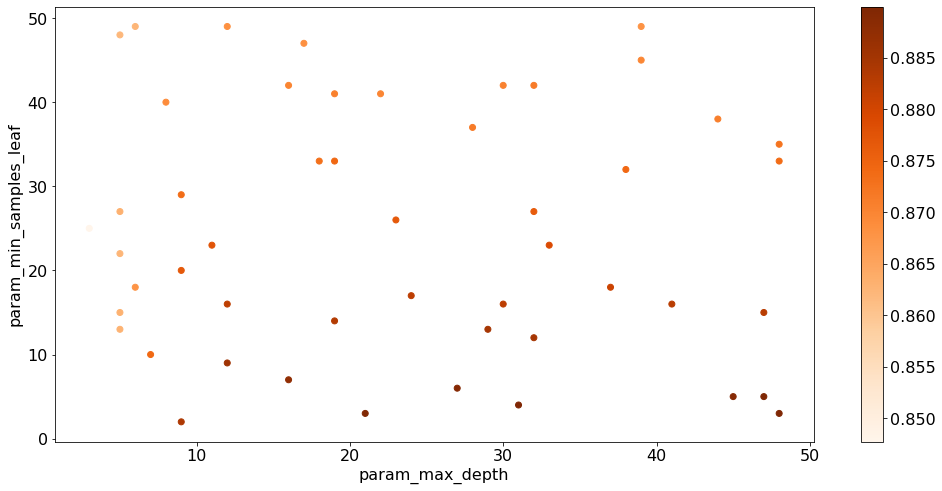

In [130]:
# Create a Random Forest Classifier with specified criterion
rf_class = RandomForestClassifier(criterion='entropy')

# Create the parameter grid
param_grid = {
    'max_depth': list(range(3,50)), 
    'min_samples_leaf': list(range(2,50))
} 

# Create a random search object
random_RF_class = RandomizedSearchCV(
    estimator = RandomForestClassifier(criterion='entropy'),
    param_distributions = param_grid,
    n_iter = 50,
    scoring='roc_auc', 
    n_jobs=4, 
    cv = 5, 
    refit=True, 
    return_train_score = True
)

# Fit to the training data
random_RF_class.fit(X_train, y_train).predict(X_test)

# Visualize the results of the param grid search
rfHeat = pd.DataFrame(random_RF_class.cv_results_['param_max_depth'].tolist(), columns = ['max_depth'])
rfHeat['min_samples_leaf'] = random_RF_class.cv_results_['param_min_samples_leaf'].tolist()
rfHeat['score'] = random_RF_class.cv_results_['mean_test_score'].tolist()

rfHeat = pd.DataFrame(random_RF_class.cv_results_)
rfHeat = rfHeat[["param_max_depth", "param_min_samples_leaf", "mean_test_score"]]

plt.rc('font', size=16)
plt.figure(figsize = (14,6))
plt.scatter(
    data = rfHeat,
    x = 'param_max_depth',
    y = 'param_min_samples_leaf',
    c = 'mean_test_score',
    cmap = 'Oranges'
)
plt.xlabel('param_max_depth')
plt.ylabel('param_min_samples_leaf')
plt.colorbar()
plt.show()

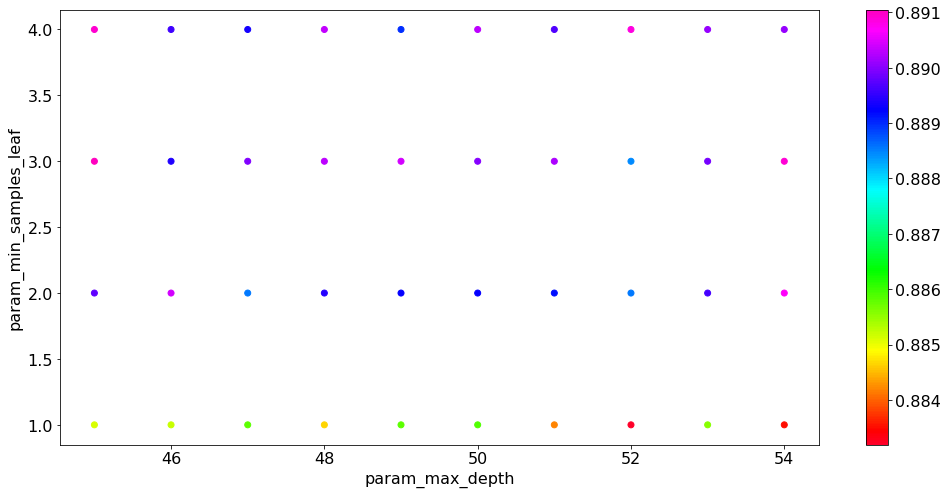

In [135]:
# Create the parameter grid
param_grid = {
    'max_depth': list(range(45,55)), 
    'min_samples_leaf': list(range(1,5)),
} 

# Create a GridSearchCV object
grid_rf_class = GridSearchCV(
    estimator=rf_class,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=4,
    cv=5,
    refit=True, return_train_score=True)

# Fit to the training data
grid_rf_class.fit(X_train, y_train).predict(X_test)

# Visualize the results of the param grid search
rfHeat = pd.DataFrame(grid_rf_class.cv_results_['param_max_depth'].tolist(), columns = ['max_depth'])
rfHeat['min_samples_leaf'] = grid_rf_class.cv_results_['param_min_samples_leaf'].tolist()
rfHeat['score'] = grid_rf_class.cv_results_['mean_test_score'].tolist()

rfHeat = pd.DataFrame(grid_rf_class.cv_results_)
rfHeat = rfHeat[["param_max_depth", "param_min_samples_leaf", "mean_test_score"]]

plt.rc('font', size=16)
plt.figure(figsize = (14,6))
plt.scatter(
    data = rfHeat,
    x = 'param_max_depth',
    y = 'param_min_samples_leaf',
    c = 'mean_test_score',
    cmap = 'gist_rainbow'
)
plt.xlabel('param_max_depth')
plt.ylabel('param_min_samples_leaf')
plt.colorbar()
plt.show()

In [137]:
rf = RandomForestClassifier(criterion='entropy', max_depth=45, min_samples_leaf=3)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.06733353, 0.06863119, 0.0782059 , 0.06514538, 0.08267894,
       0.07982104, 0.08314157, 0.01566274, 0.08232595, 0.1587005 ,
       0.03391722, 0.0178805 , 0.05382341, 0.00453979, 0.01201731,
       0.00077179, 0.00829018, 0.00809853, 0.00280231, 0.01414264,
       0.02024234, 0.0207626 , 0.        , 0.02106463])

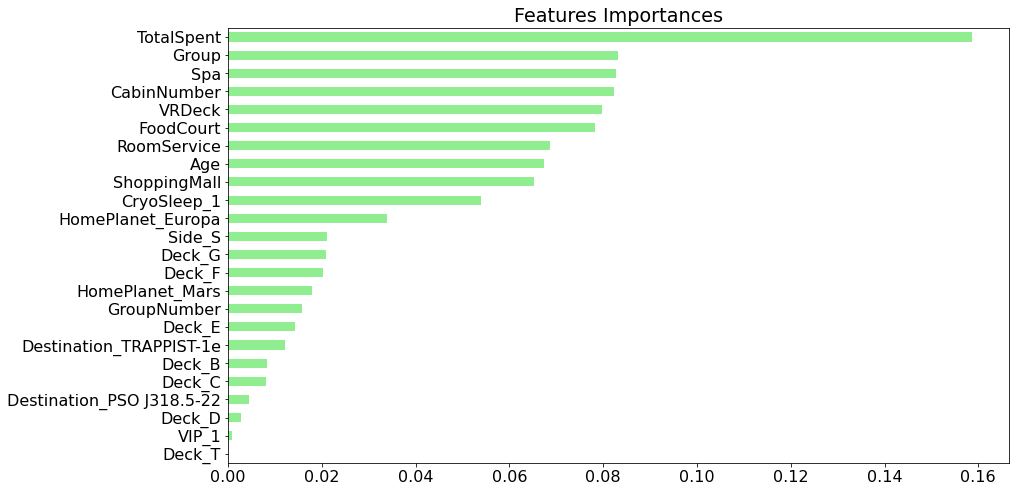

In [140]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.rc('font', size=16)
plt.figure(figsize = (14,8))
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [144]:
test = pd.read_csv('data/test.csv')

OSError: [Errno 22] Invalid argument: 'data/test.csv'